In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.stats.api as sms
from scipy.stats import (ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu,
                         pearsonr, spearmanr, kendalltau, f_oneway, kruskal)
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import MultiComparison


In [4]:
# TODO : Import the Data from the kaggle API
from google.colab import files
files.upload()
ab_test_data = pd.read_csv('AB_Test_Results.csv')
print(ab_test_data.head())
print(ab_test_data.info())


Saving AB_Test_Results.csv to AB_Test_Results (1).csv
   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None


# Data Understanding

In [6]:
#TODO : compute the following : DataFrame Information, Columns in DataFrame, Counting Missing Values, Descriptive Statistics, Value Counts for VARIANT_NAME, Counting Unique Users in USER_ID

data_info = ab_test_data.info()
columns = ab_test_data.columns.tolist()
missing_values_count = ab_test_data.isnull().sum()
descriptive_stats = ab_test_data.describe()
variant_value_counts = ab_test_data['VARIANT_NAME'].value_counts()
unique_users_count = ab_test_data['USER_ID'].nunique()

# Print results
print(f"DataFrame Information: {data_info}\n")
print(f"Columns in DataFrame: {columns}\n")
print(f"Counting Missing Values: {missing_values_count.to_dict()}\n")
print(f"Descriptive Statistics: {descriptive_stats.to_dict()}\n")
print(f"Value Counts for VARIANT_NAME: {variant_value_counts.to_dict()}\n")
print(f"Counting Unique Users in USER_ID: {unique_users_count}\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
DataFrame Information: None

Columns in DataFrame: ['USER_ID', 'VARIANT_NAME', 'REVENUE']

Counting Missing Values: {'USER_ID': 0, 'VARIANT_NAME': 0, 'REVENUE': 0}

Descriptive Statistics: {'USER_ID': {'count': 10000.0, 'mean': 4981.0802, 'std': 2890.5901148535654, 'min': 2.0, '25%': 2468.75, '50%': 4962.0, '75%': 7511.5, 'max': 10000.0}, 'REVENUE': {'count': 10000.0, 'mean': 0.09944700000000001, 'std': 2.3185286544931945, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 0.0, 'max': 196.01}}

Value Counts for VARIANT_NAME: {'variant': 5016, 'control': 4984}

Counting Unique Users in USER_ID: 6324



# Average Revenue by VARIANT_NAME

In [7]:
#TODO

average_revenue_by_variant = ab_test_data.groupby('VARIANT_NAME')['REVENUE'].mean()
print("Average Revenue by VARIANT_NAME:")
print(average_revenue_by_variant)


Average Revenue by VARIANT_NAME:
VARIANT_NAME
control    0.129013
variant    0.070070
Name: REVENUE, dtype: float64


What if H0: M1 = M2 ?
What about H1: M1 1= M2 ?

# Assumptions Control:
*# 1- Normality Assumptions*
*# 2- Homogeneity of Variances Assumption*

In [9]:
# TODO : test the normality of revenue data in two groups (variant and control) within your DataFrame df using the Shapiro-Wilk test, what can you conclude ?

# Redefine the control and variant groups
control_group = ab_test_data[ab_test_data['VARIANT_NAME'] == 'control']['REVENUE']
variant_group = ab_test_data[ab_test_data['VARIANT_NAME'] == 'variant']['REVENUE']

# Perform the Shapiro-Wilk test for normality
shapiro_control_stat, shapiro_control_p = shapiro(control_group)
shapiro_variant_stat, shapiro_variant_p = shapiro(variant_group)

# Display the results
print("Control Group:")
print(f"Shapiro-Wilk Statistic: {shapiro_control_stat}, p-value: {shapiro_control_p}")

print("\nVariant Group:")
print(f"Shapiro-Wilk Statistic: {shapiro_variant_stat}, p-value: {shapiro_variant_p}")



Control Group:
Shapiro-Wilk Statistic: 0.01833147442513483, p-value: 2.4983285100057203e-95

Variant Group:
Shapiro-Wilk Statistic: 0.027033073451830147, p-value: 2.7310104028899288e-95


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5016.
  res = hypotest_fun_out(*samples, **kwds)


Both groups have p-values very close to 0 (much less than 0.05), which means the null hypothesis (that the data is normally distributed) is rejected.
Additionally, the warning from SciPy indicates that the test's p-value may not be accurate for large sample sizes greater than  
5000, as is the case here. However, even without precise p-values, it is clear the data strongly deviates from normality.
Conclusion:
The revenue data in both the control and variant groups does not follow a normal distribution. Because of this, non-parametric statistical methods such as the Mann-Whitney U test may be better suited for comparing these groups.



---

For large datasets, consider using alternative methods for testing normality:
Kolmogorov-Smirnov Test:
Less sensitive to large sample sizes.
Compares the sample distribution to a normal distribution.

---



In [10]:
from scipy.stats import kstest

# Performing  Kolmogorov-Smirnov test for normality on control group
ks_control_stat, ks_control_p = kstest(control_group, 'norm', args=(control_group.mean(), control_group.std()))

# Performing Kolmogorov-Smirnov test for normality on variant group
ks_variant_stat, ks_variant_p = kstest(variant_group, 'norm', args=(variant_group.mean(), variant_group.std()))


print("Kolmogorov-Smirnov Test Results:")
print("Control Group:")
print(f"KS Statistic: {ks_control_stat}, p-value: {ks_control_p}")
print("\nVariant Group:")
print(f"KS Statistic: {ks_variant_stat}, p-value: {ks_variant_p}")


Kolmogorov-Smirnov Test Results:
Control Group:
KS Statistic: 0.5010566932169329, p-value: 0.0

Variant Group:
KS Statistic: 0.5068967164402843, p-value: 0.0



Kolmogorov-Smirnov Test Results:

Control Group:
KS Statistic: 0.5011
p-value: 0.0

Variant Group:
KS Statistic: 0.5069
p-value: 0.0

Interpretation:
Both groups have p-values of 0, which are less than the standard significance level (e.g., 0.05).
This indicates that we reject the null hypothesis, which assumes that the data follows a normal distribution.
Conclusion:
The Kolmogorov-Smirnov test further confirms that the revenue data for both the control and variant groups does not follow a normal distribution. Based on this, it would be more appropriate to use non-parametric methods for comparing these groups.

In [11]:
# TODO : test for the homogeneity of variances between two groups (variant and control) within your DataFrame df using the Levene's test,  what can you conclude ?

levene_stat, levene_p = levene(control_group, variant_group)

print("Levene's Test Results:")
print(f"Statistic: {levene_stat}")
print(f"p-value: {levene_p}")


Levene's Test Results:
Statistic: 1.6158565214488871
p-value: 0.2037000785338918


The null hypothesis of Levene's test assumes that the variances of the two groups are equal.
Since the p-value (0.204) is greater than the significance level (e.g., 0.05), we fail to reject the null hypothesis.
Conclusion:
There is no statistically significant difference in the variances between the control and variant groups. This suggests that the assumption of equal variances holds.

# Non-Parametric Test (mannwhitneyu Test)

In [12]:
# TODO : perform the Mann-Whitney U test for comparing the average revenue between the variant and control groups in your DataFrame, what can you conclude ?
mannwhitney_stat, mannwhitney_p = mannwhitneyu(control_group, variant_group, alternative='two-sided')

# Display the results
print("Mann-Whitney U Test Results:")
print(f"Test Statistic: {mannwhitney_stat}")
print(f"p-value: {mannwhitney_p}")


Mann-Whitney U Test Results:
Test Statistic: 12521564.0
p-value: 0.47825247965294926


The Mann-Whitney U test evaluates whether there is a significant difference in the distributions of revenue between the control and variant groups.
Since the p-value (0.478) is greater than the significance level (e.g., 0.05), we fail to reject the null hypothesis.

Conclusion:
There is no statistically significant difference in the revenue distributions between the control and variant groups. This result suggests that the variant does not significantly affect revenue compared to the control.

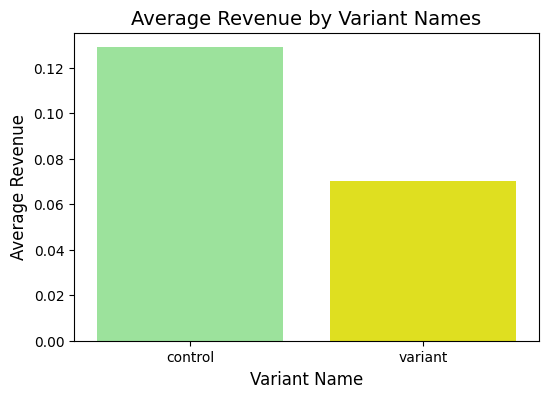

In [19]:
# TODO : create a bar plot showing the average revenues by variant names using the seaborn library
average_revenue = ab_test_data.groupby('VARIANT_NAME')['REVENUE'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(
    x='VARIANT_NAME',
    y='REVENUE',
    data=average_revenue,
    hue='VARIANT_NAME',
    dodge=False,
    palette=["lightgreen", "yellow"]
)
plt.title('Average Revenue by Variant Names', fontsize=14)
plt.xlabel('Variant Name', fontsize=12)
plt.ylabel('Average Revenue', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend([],[], frameon=False)
plt.show()



Based on the statistical tests, there is no statistically significant difference in revenue between the control and variant groups.
Although the bar chart visually shows a difference, statistical analysis suggests that this difference could be due to random variation rather than a real effect.